In [1]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from yoda.alignments import load_rfam
from yoda import graphs as ygraphs

import cmcomp
import matplotlib as mpl
mpl.rc("figure", dpi=100)

import matplotlib.pyplot as plt

In [2]:
a,l = load_rfam(full= False, add_cov= False)

# CMCOMPARE

In [3]:

data = {}
runtime = {}
# THIS IS HOW WE WOULD RERUN THE CALCULATION
# names = [aa.gf["AC"][3:] for aa in a]
# [cmcomp.dumpcm(name) for name in names]
# IMPORTANTRESULT = cmcomp.run_cmcompare_pairwise()
# IMPORTANTRESULT.to_csv('cmcompare_full_run')

# LOAD CMCOMP DATA
data['CMCompare'] = cmcomp.loadcmcomp('cmcompare_full_run_2024_06_27')
runtime['CMCompare'] = f"12h"



# KRAID


In [4]:
import time
start = time.time()
matrix = ygraphs.alignment_to_vectors(a)



'''
def mkdf(mat):
    sim = mat @ mat.T
    # sim = -euclidean_distances(mat)
    data = [{'cm1':a, 'cm2':b , 'score1': sim[a,b]} for a in Range(l) for b in Range(l)]
    return pd.DataFrame(data)
#yoda_data = mkdf(matrix)
#yoda_dist = cmcomp.to_dist(cmcomp.pivot_numpy(yoda_data))
'''

from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
ourmethod = 'KRAID'
data[ourmethod] = cosine_distances(matrix)
runtime[ourmethod] = f"{time.time() - start:.2}s"


In [5]:
# one could do it like this:
# a,l = load_rfam(full= False, add_cov= False)
# graphs = lmz.Map(ali2graph.writecons, a)
#eden_sim = ygraphs.vectorize_graphs(graphs, normalization=True, min_r = 2,min_d=1, inner_normalization=True)
# data['NSPDK'] = mkdist(eden_sim)
start = time.time()
data['NSPDK'] = cosine_distances(ygraphs.vectorize_graphs([alignment.graph for alignment in a]))

runtime['NSPDK'] = f"{time.time() - start:.2}s"


# INFERNAL

In [6]:

data['Infernal']=cmcomp.infernal_tbl_to_dist(a,l,'inftools/infernal.tbl')
data['Infernal_global']=cmcomp.infernal_tbl_to_dist(a,l,'inftools/infernal_global.tbl')

runtime['Infernal'] = '904 s'
runtime['Infernal_global'] = '846 s'




# clan discovery

In [7]:
randomarray = np.random.rand(395,395)
np.fill_diagonal(randomarray, 0)
data['random']= randomarray
runtime['random'] = 'n/a'

In [8]:
# k clans plot
# we also need to collect the results for the other normed methods -> 3 x 2 lines are in this plot
figpath =  !echo $HOME/pigplot/
figpath = figpath[0]
figpath

'/home/ubuntu/pigplot/'

In [9]:
#sns.reset_defaults()
# FULL PLOT

# z = sns.color_palette("muted")
# huemap = dict(zip(np.unique(df.Method),z.as_hex()))
# print(huemap)

#sns.reset_defaults()
# REDUCED PLOT


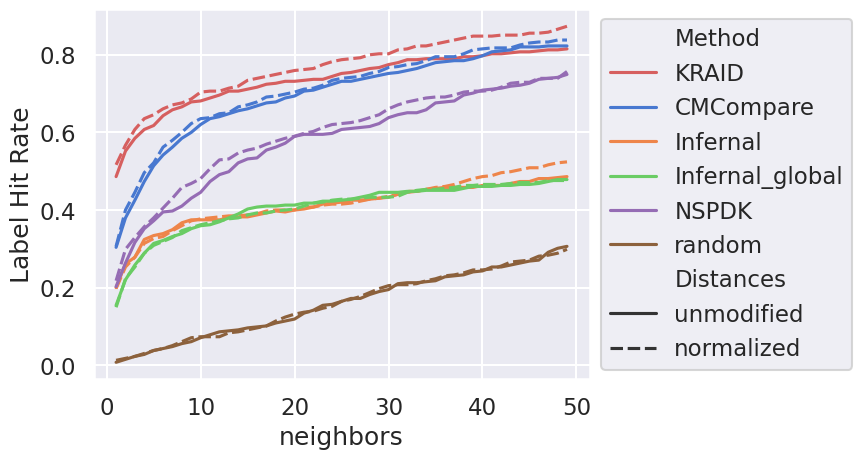

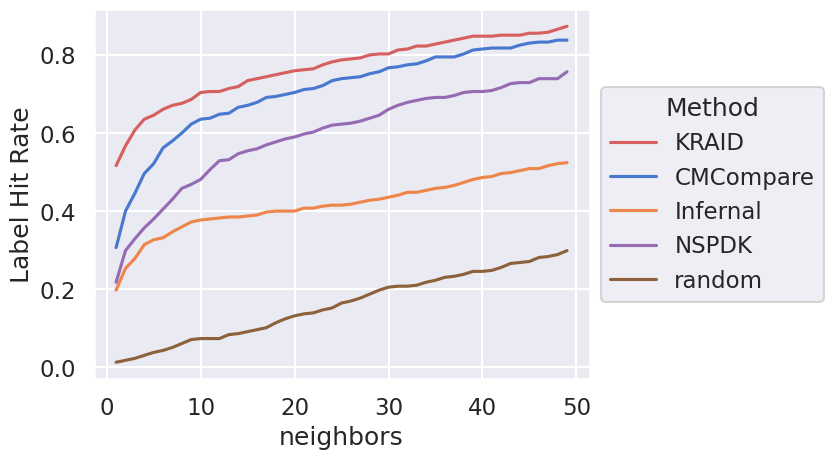

In [10]:

df_hit = cmcomp.mkHitRateData(data,l)

ax = cmcomp.plot_hitrate_plusCSLS(df_hit)
ax.get_figure().savefig(figpath + '350hitrate_full.png' ,  bbox_inches='tight')
ax = cmcomp.plot_hitrate_noCSLS(df_hit)
ax.get_figure().savefig(figpath + '350hitrate.png',bbox_inches='tight')



In [11]:
import numpy as np
from yoda.ml import nearneigh

# Example usage (assuming 'data' is defined and 'l' contains the labels)
results = cmcomp.collect_results_precrec(data, l)#%%


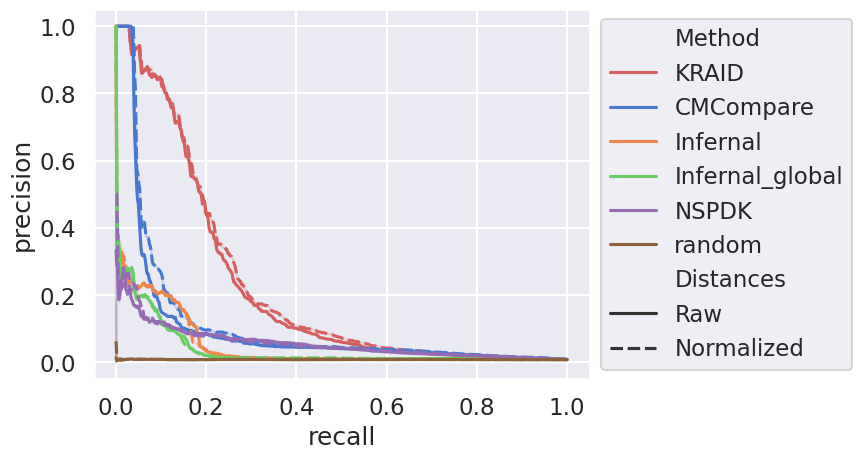

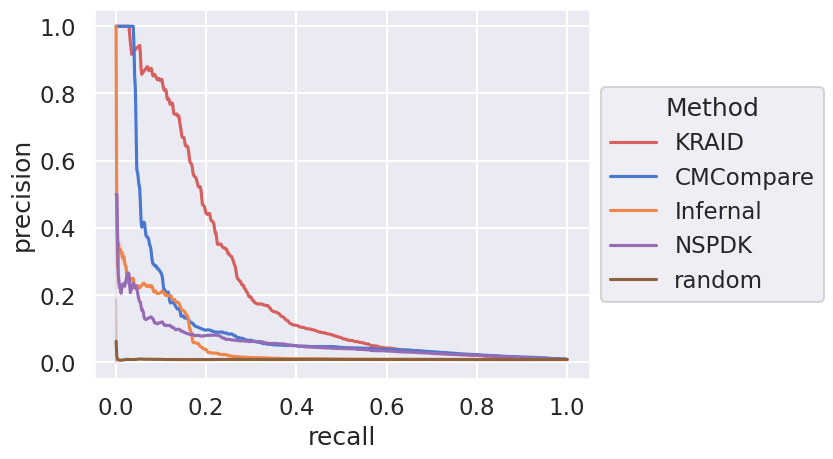

In [12]:
import pandas as pd

# Constant for the plot title


# Original dataframe creation and full-data plot
df = pd.DataFrame(results)
ax = cmcomp.plot_precision_recall_curve(df, style_column='Distances')
ax.get_figure().savefig(figpath + '350precrec_full.png', bbox_inches='tight')

# Filtering the dataframe and plotting filtered data
filtered_df = df[(df['Distances'] == 'Normalized') & (df['Method'] != 'Infernal_global')]
ax = cmcomp.plot_precision_recall_curve(filtered_df)

ax.get_figure().savefig(figpath + '350precrec.png', bbox_inches='tight')


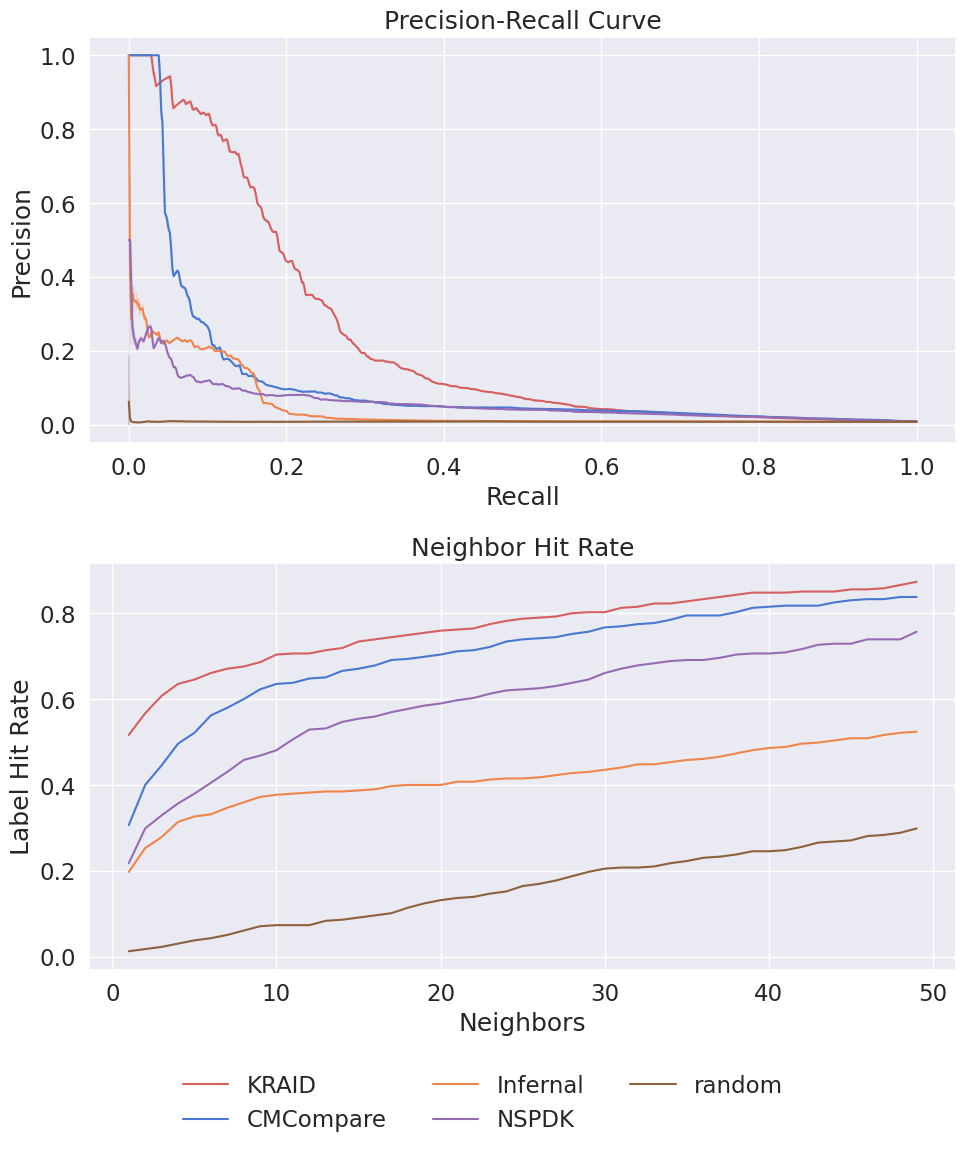

CPU times: user 42.9 s, sys: 53 ms, total: 42.9 s
Wall time: 42.9 s


In [26]:
%%time
# fig = cmcomp.slobplot(df_hit,df)
fig = cmcomp.slopplot_vertical(df_hit,df)
fig.savefig(figpath + '350eval.png', bbox_inches='tight')

In [14]:
df2 = cmcomp.make_results_table(data,l, runtime)
print(df2.to_latex(index=True,  header=True, float_format="%.2f"))

df2

CMCompare raw AUC: 0.09712015707241435
CMCompare raw mAP: 0.262255061610186
CMCompare normalized AUC: 0.11093857301034973
CMCompare normalized mAP: 0.271388080389606
KRAID raw AUC: 0.2184425729752794
KRAID raw mAP: 0.3699777932177119
KRAID normalized AUC: 0.22765102132933424
KRAID normalized mAP: 0.39166894245200407
NSPDK raw AUC: 0.05602802843498729
NSPDK raw mAP: 0.18294077545982243
NSPDK normalized AUC: 0.057295085416788266
NSPDK normalized mAP: 0.1975298690069321
Infernal raw AUC: 0.04719019333504475
Infernal raw mAP: 0.1312960022349525
Infernal normalized AUC: 0.04750583869759636
Infernal normalized mAP: 0.12970392609516537
Infernal_global raw AUC: 0.03760285256672859
Infernal_global raw mAP: 0.11825295935134558
Infernal_global normalized AUC: 0.03853755397252841
Infernal_global normalized mAP: 0.11846274281374627
random raw AUC: 0.008268412859600276
random raw mAP: 0.020200692901197848
random normalized AUC: 0.008282287391755136
random normalized mAP: 0.02121041073324298
\begin{t

scoretype       Average Precision           Precision/Recall AUC            \
normalized                     no       yes                   no       yes   
method                                                                       
CMCompare                0.262255  0.271388             0.097120  0.110939   
Infernal                 0.131296  0.129704             0.047190  0.047506   
Infernal_global          0.118253  0.118463             0.037603  0.038538   
KRAID                    0.369978  0.391669             0.218443  0.227651   
NSPDK                    0.182941  0.197530             0.056028  0.057295   
random                   0.020201  0.021210             0.008268  0.008282   

scoretype       runtime  
normalized               
method                   
CMCompare           12h  
Infernal          904 s  
Infernal_global   846 s  
KRAID              7.7s  
NSPDK              3.5s  
random              n/a

In [15]:
# collect data on rf15 vs 14... 
import yoda.alignments.clans as claner
claner.stats()

rf15 total
len(d)=143 sum([len(v) for v in d.values()])=449
train
len(d)=126 sum([len(v) for v in d.values()])=395
extender=[('CL00098', 'MIR169_3'), ('CL00098', 'MIR169_6'), ('CL00098', 'MIR169_7'), ('CL00098', 'MIR169_8'), ('CL00088', 'mir-35_2'), ('CL00088', 'mir-36_2'), ('CL00088', 'mir-39'), ('CL00127', 'c-di-GMP-II-GCG')]
justnew=['CL00145', 'CL00144', 'CL00147', 'CL00146', 'CL00141', 'CL00140', 'CL00143', 'CL00142', 'CL00149', 'CL00148', 'CL00150', 'CL00135', 'CL00136', 'CL00137', 'CL00133', 'CL00138', 'CL00139']
test
len(d)=143 sum([len(v) for v in d.values()])=449
395
